In [31]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xarray as xr
import cartopy
import pandas as pn
from datetime import datetime
import gsw
from holteandtalley import HolteAndTalley
import os
from xmovie import Movie
from shapely.geometry import Polygon, Point, MultiPolygon
import shapefile
import geopandas as gpd
import cartopy
import cartopy.crs as ccrs

## Opening the Phosphate Data from the World Ocean Database

In [2]:
# First set up the dataframe with the initial netcdf
array = xr.open_dataset("/Users/nyelab/Downloads/ocldb1625068230.20558.OSD/wod_013574410O.nc")
data = pn.DataFrame(data = array.Phosphate, columns = ['phosphate'])
k=1
data['depth'] = array.z.values 
year = pn.to_datetime(array.time.values).year
month = pn.to_datetime(array.time.values).month
day = pn.to_datetime(array.time.values).day
data['year']=year
data['month']=month
data['day']=day
data['lat']=array.lat.values
data['lon']=array.lon.values
data['station']=k

In [3]:
# Next cycle through all netcdfs and append new data to the dataframe
k=2
for i in os.listdir("/Users/nyelab/Downloads/ocldb1625068230.20558.OSD/"):
    if i.startswith("wo"):
        string = '/Users/nyelab/Downloads/ocldb1625068230.20558.OSD/'+i
        array = xr.open_dataset(string)
        data2 = pn.DataFrame(data = array.Phosphate, columns = ['phosphate'])
        data2['depth'] = array.z.values 
        year = pn.to_datetime(array.time.values).year
        month = pn.to_datetime(array.time.values).month
        day = pn.to_datetime(array.time.values).day
        data2['year']=year
        data2['month']=month
        data2['day']=day
        data2['lat']=array.lat.values
        data2['lon']=array.lon.values
        data2['station']=k
        k=k+1
        data = data.append(data2)
        array.close()

In [4]:
# index needed to be reset
data = data.reset_index()
data

,index,phosphate,depth,year,month,day,lat,lon,station
0,0,6.200000e-02,4.056877,2007,7,26,39.349201,-74.085197,1
1,1,-1.000000e+10,4.190848,2007,7,26,39.349201,-74.085197,1
2,2,-1.000000e+10,4.332758,2007,7,26,39.349201,-74.085197,1
3,3,7.800002e-02,10.047769,2007,7,26,39.349201,-74.085197,1
4,4,-1.000000e+10,10.091433,2007,7,26,39.349201,-74.085197,1
...,...,...,...,...,...,...,...,...,...
1615,14,1.131707e+00,1774.000000,1982,6,13,38.208332,-72.951668,209
1616,15,1.112195e+00,1970.000000,1982,6,13,38.208332,-72.951668,209
1617,16,1.131707e+00,2166.000000,1982,6,13,38.208332,-72.951668,209
1618,17,1.121951e+00,2357.000000,1982,6,13,38.208332,-72.951668,209


In [5]:
# Load NYB shapefile
NYB = gpd.read_file('/Users/nyelab/Desktop/NYB Indicators/Datasets/Shapefiles/PlanningArea_NYocean_NYSDOS.shp')

In [6]:
# Alter the projection to WGS84 see https://epsg.io/4326
NYB = NYB.to_crs(epsg=4326)

In [7]:
# Extract the polygon
nyb_shape = NYB.geometry[0]

In [8]:
def inNYB(dataframe, shape, lon_col_name, lat_col_name):
    yn = str(input("Does your dataframe have a NYB column? y/n"))
    if yn == 'y':
        print ('Great, starting inNYB')
    else:
        print ('OK, a NYB column has been added')
        dataframe['NYB'] = np.nan
    for i in range(len(dataframe)):
        if Point(dataframe[lon_col_name][i], dataframe[lat_col_name][i]).within(shape) == True:
            dataframe['NYB'][i] = 'NYB'
    return dataframe

In [9]:
#check which points are within the NYB
data = inNYB(data, nyb_shape, 'lon', 'lat')

Does your dataframe have a NYB column? y/n n


OK, a NYB column has been added


<ipython-input-8-ff8895e12bd9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['NYB'][i] = 'NYB'
/Users/nyelab/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [10]:
# subset for NYB data only
NYB_data = data[data.NYB == 'NYB']

In [16]:
# get one each lat lon and year for each station
LON = NYB_data[NYB_data.station == 4].lon
LAT = NYB_data[NYB_data.station == 4].lat
YEAR = NYB_data[NYB_data.station == 4].year

for i in NYB_data.station.unique()[1:]:
    LON = LON.append(NYB_data[NYB_data.station == i].lon)
    LAT = LAT.append(NYB_data[NYB_data.station == i].lat)
    YEAR = YEAR.append(NYB_data[NYB_data.station == i].year)

TypeError: 'Text' object is not callable

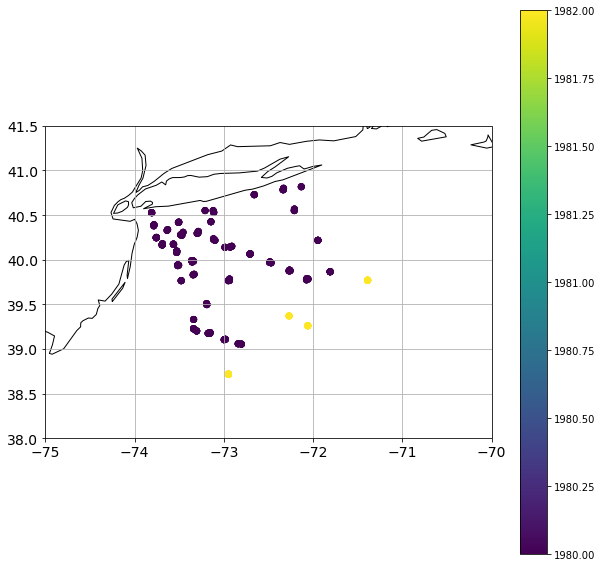

In [36]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})
extent = [285,290,38.5,41.5]
ax.set_extent(extent)
ax.gridlines()
ax.coastlines(resolution='50m')
C = ax.scatter(LON,LAT,c=YEAR)
fig.colorbar(C)
ax.set_xticks(np.arange(-75,-69,1), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(38,42,0.5), crs=ccrs.PlateCarree())
ax.tick_params(labelsize=14)
plt.title('Phosphate', fontsize = 14, fontweight = 'bold')

In [ ]:
NYB_data.

In [ ]:
array = xr.open_dataset("/Users/nyelab/Downloads/ocldb1625068230.20558.OSD/wod_013574410O.nc")

In [ ]:
data2 = pn.DataFrame(data = array.Phosphate, columns = ['phosphate'])

In [ ]:
k=1
data2['depth'] = array.z.values 
year = pn.to_datetime(array.time.values).year
month = pn.to_datetime(array.time.values).month
day = pn.to_datetime(array.time.values).day
data2['year']=year
data2['month']=month
data2['day']=day
data2['lat']=array.lat.values
data2['lon']=array.lon.values
data2['station']=k

In [ ]:
data2

In [ ]:
array

In [ ]:
X = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
Y = [15,14,13,12,11,10,9,8,7,6,5,4,3,2,1]

In [ ]:
len([40,100,25,50,30,120,-80,-60,-110,-30,20,50,-20,-30,-40])

In [ ]:
#help(plt.quiver)

plt.quiver(X,Y, [100,200,40,20,-10,-30,-20,-60,-80,-10,20,40,50,80,20], [40,100,25,50,30,120,-80,-60,-110,-30,20,50,-20,-30,-40], scale = 1000)
#plt.xlim([-0.04,0.04])
plt.ylim([0,20])